<a href="https://colab.research.google.com/github/MoniFarsang/NeuroAI/blob/main/Forward_activation_with_deactivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn ncps

In [2]:
# Import libraries
import numpy as np
import os
from tensorflow import keras
from ncps import wirings
from ncps.tf import LTC
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange

## Generating data for forward activation with deactivation

In [3]:
def generate_forward_activation_with_deactivation(n=100):
  N = 48 # Length of the time-series
  x_train_forward_activation_with_deactivation = []
  y_train_forward_activation_with_deactivation = []

  for i in range(n): 

    # Initialize the time-series data
    data_x, data_y = [0] * N,  [0] * N

    # Set the signal of the input data
    # Generate signals with different start time and activation length 
    i_start = 2 + randrange(20)
    input_active_length = 2 + randrange(4)
    data_x[i_start:(i_start + input_active_length)] = [1] * input_active_length # Activate signal from i_start input_active_length long

    x_train_forward_activation_with_deactivation.append(data_x)

    # Target output is a delayed activation 
    output_delay = 1 # Delay between the input activation and the output activation
    output_active_length = input_active_length +2

    data_y[(i_start+output_delay):(i_start+output_delay+output_active_length)] = [1] * output_active_length # Activate signal for output_active_length long

    y_train_forward_activation_with_deactivation.append(data_y)
  
  x_train_forward_activation_with_deactivation = np.stack(x_train_forward_activation_with_deactivation, axis=0)
  y_train_forward_activation_with_deactivation = np.stack(y_train_forward_activation_with_deactivation, axis=0)

  # Print shapes
  print("x_train_forward_activation_with_deactivation.shape: ", str(x_train_forward_activation_with_deactivation.shape))
  print("y_train_forward_activation_with_deactivation.shape: ", str(y_train_forward_activation_with_deactivation.shape))

  return x_train_forward_activation_with_deactivation, y_train_forward_activation_with_deactivation

In [4]:
x_train_forward_activation_with_deactivation, y_train_forward_activation_with_deactivation = generate_forward_activation_with_deactivation(100)

x_train_forward_activation_with_deactivation.shape:  (100, 48)
y_train_forward_activation_with_deactivation.shape:  (100, 48)


In [5]:
x_valid_forward_activation_with_deactivation, y_valid_forward_activation_with_deactivation = generate_forward_activation_with_deactivation(20)

x_train_forward_activation_with_deactivation.shape:  (20, 48)
y_train_forward_activation_with_deactivation.shape:  (20, 48)


In [6]:
x_test_forward_activation_with_deactivation, y_test_forward_activation_with_deactivation = generate_forward_activation_with_deactivation(10)

x_train_forward_activation_with_deactivation.shape:  (10, 48)
y_train_forward_activation_with_deactivation.shape:  (10, 48)


<Figure size 800x400 with 0 Axes>

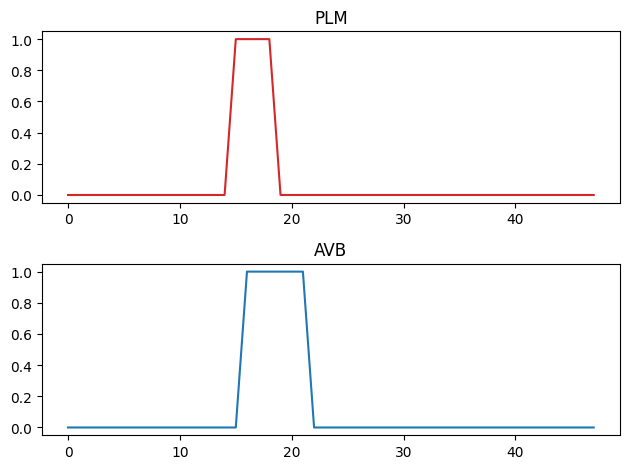

In [7]:
# Plotting the training data
plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(2,1)
axs[0].plot(x_train_forward_activation_with_deactivation[0, :], 'tab:red')
axs[0].set_title('PLM')
axs[1].plot(y_train_forward_activation_with_deactivation[0, :], 'tab:blue')
axs[1].set_title('AVB')

plt.tight_layout()
plt.show()

## Define Forward circuit

In [8]:
class Forward(wirings.Wiring):
    def __init__(self, units=1, output_dim=1):
        super(Forward, self).__init__(units)
        self.set_output_dim(output_dim)
        self.sparsity_level = 0 # Need no sparsity, all the connections are defined in the build function

    def build(self, input_shape):
        super().build(input_shape)
        self.sensory_adjacency_matrix[0,0] = 1 #idx0: source neuron index from sensory neurons, idx1: destination neuron index from units (shape: [input_dim, units])
        self.adjacency_matrix[0,0] = 1 #idx0: source neuron index from units, idx1: destination neuron index from units (shape: [units, units])

## Create and compile keras model for the second dataset: Forward activation with deactivation

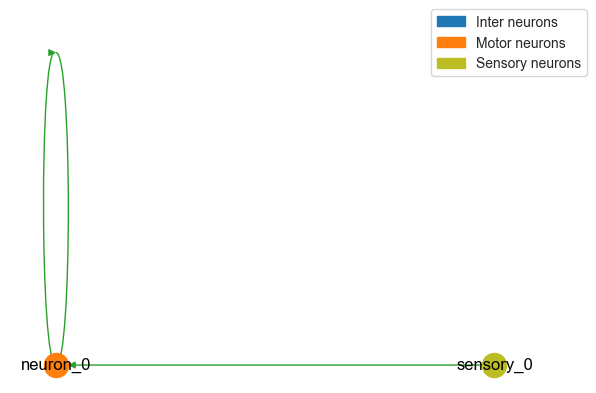

In [9]:
forward_architecture = Forward(1,1) 

ncp_model_with_deactivation = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 1)),
        LTC(forward_architecture, return_sequences=True, input_mapping=None, output_mapping=None),
    ]
)
ncp_model_with_deactivation.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = forward_architecture.draw_graph(draw_labels=True)
plt.legend(handles=legend_handles, bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Fit the dataset (PLM activates AVB, AVB stays active for some period, then deactivates)

In [10]:
hist_forward_ncp_with_deactivation = ncp_model_with_deactivation.fit(x=x_train_forward_activation_with_deactivation, y=y_train_forward_activation_with_deactivation, batch_size=32, epochs=100, validation_data=(x_valid_forward_activation_with_deactivation, y_valid_forward_activation_with_deactivation))

Epoch 1/100
4/4 [==============================] - 28s 915ms/step - loss: 0.0788 - val_loss: 0.0605
Epoch 2/100
4/4 [==============================] - 1s 249ms/step - loss: 0.0577 - val_loss: 0.0518
Epoch 3/100
4/4 [==============================] - 1s 227ms/step - loss: 0.0503 - val_loss: 0.0456
Epoch 4/100
4/4 [==============================] - 1s 245ms/step - loss: 0.0436 - val_loss: 0.0363
Epoch 5/100
4/4 [==============================] - 1s 216ms/step - loss: 0.0334 - val_loss: 0.0272
Epoch 6/100
4/4 [==============================] - 1s 272ms/step - loss: 0.0288 - val_loss: 0.0265
Epoch 7/100
4/4 [==============================] - 1s 340ms/step - loss: 0.0253 - val_loss: 0.0253
Epoch 8/100
4/4 [==============================] - 1s 257ms/step - loss: 0.0259 - val_loss: 0.0246
Epoch 9/100
4/4 [==============================] - 1s 278ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 10/100
4/4 [==============================] - 1s 345ms/step - loss: 0.0242 - val_loss: 0.0233
Epoch 11

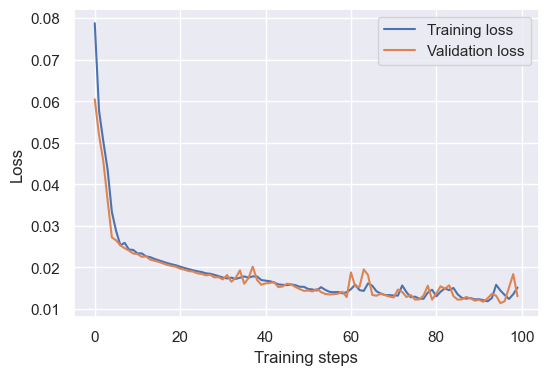

In [11]:
# Plotting the history data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist_forward_ncp_with_deactivation.history["loss"], label="Training loss")
plt.plot(hist_forward_ncp_with_deactivation.history["val_loss"], label="Validation loss")

plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [12]:
y_test_forward_activation_with_deactivation_predicted = ncp_model_with_deactivation.predict(x_test_forward_activation_with_deactivation)

1/1 [==============================] - 3s 3s/step


<Figure size 800x400 with 0 Axes>

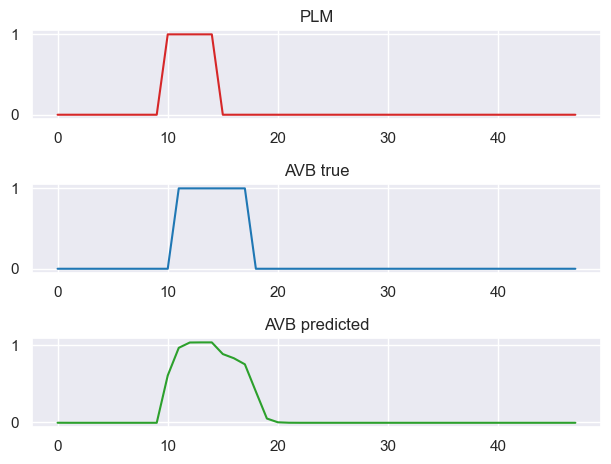

In [13]:
# Plotting the training data
plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(3,1)
axs[0].plot(x_test_forward_activation_with_deactivation[0, :], 'tab:red')
axs[0].set_title('PLM')
axs[1].plot(y_test_forward_activation_with_deactivation[0, :], 'tab:blue')
axs[1].set_title('AVB true')
axs[2].plot(np.squeeze(y_test_forward_activation_with_deactivation_predicted[0, :]), 'tab:green')
axs[2].set_title('AVB predicted')

plt.tight_layout()
plt.show()

## Print learned weights

In [14]:
ncp_model_with_deactivation.variables

[<tf.Variable 'ltc/ltc_cell/gleak:0' shape=(1,) dtype=float32, numpy=array([0.49387395], dtype=float32)>,
 <tf.Variable 'ltc/ltc_cell/vleak:0' shape=(1,) dtype=float32, numpy=array([-0.02624898], dtype=float32)>,
 <tf.Variable 'ltc/ltc_cell/cm:0' shape=(1,) dtype=float32, numpy=array([0.18542072], dtype=float32)>,
 <tf.Variable 'ltc/ltc_cell/sigma:0' shape=(1, 1) dtype=float32, numpy=array([[8.857708]], dtype=float32)>,
 <tf.Variable 'ltc/ltc_cell/mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.76475394]], dtype=float32)>,
 <tf.Variable 'ltc/ltc_cell/w:0' shape=(1, 1) dtype=float32, numpy=array([[0.9578251]], dtype=float32)>,
 <tf.Variable 'ltc/ltc_cell/erev:0' shape=(1, 1) dtype=float32, numpy=array([[1.4785218]], dtype=float32)>,
 <tf.Variable 'ltc/ltc_cell/sensory_sigma:0' shape=(1, 1) dtype=float32, numpy=array([[7.176077]], dtype=float32)>,
 <tf.Variable 'ltc/ltc_cell/sensory_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.53925955]], dtype=float32)>,
 <tf.Variable 'ltc/ltc_ce

## Define Forward circuit without self-loop

In [15]:
class Forward_without_loop(wirings.Wiring):
    def __init__(self, units=1, output_dim=1):
        super(Forward_without_loop, self).__init__(units)
        self.set_output_dim(output_dim)
        self.sparsity_level = 0 # Need no sparsity, all the connections are defined in the build function

    def build(self, input_shape):
        super().build(input_shape)
        self.sensory_adjacency_matrix[0,0] = 1 #idx0: source neuron index from sensory neurons, idx1: destination neuron index from units (shape: [input_dim, units])
        #self.adjacency_matrix[0,0] = 1 #idx0: source neuron index from units, idx1: destination neuron index from units (shape: [units, units])

## Create and compile keras model

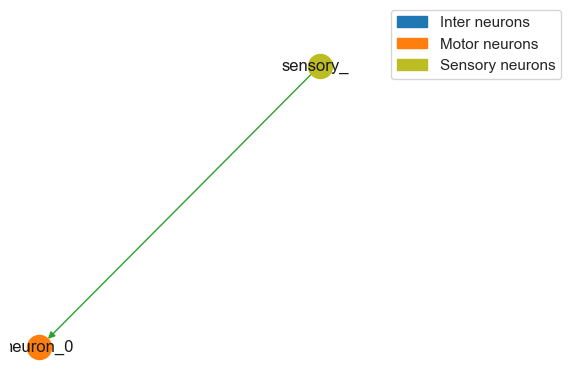

In [16]:
forward_without_loop_architecture = Forward_without_loop(1,1) 

ncp_model_with_deactivation_without_selfloop = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 1)),
        LTC(forward_without_loop_architecture, return_sequences=True, input_mapping=None, output_mapping=None),
    ]
)
ncp_model_with_deactivation_without_selfloop.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = forward_without_loop_architecture.draw_graph(draw_labels=True)
plt.legend(handles=legend_handles, bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Fit the dataset (PLM activates AVB, AVB stays active because of its self-activation)

In [17]:
hist_forward_ncp_with_deactivation_without_selfloop = ncp_model_with_deactivation_without_selfloop.fit(x=x_train_forward_activation_with_deactivation, y=y_train_forward_activation_with_deactivation, batch_size=32, epochs=200, validation_data=(x_valid_forward_activation_with_deactivation, y_valid_forward_activation_with_deactivation))

Epoch 1/200
4/4 [==============================] - 26s 476ms/step - loss: 0.0884 - val_loss: 0.0783
Epoch 2/200
4/4 [==============================] - 1s 241ms/step - loss: 0.0761 - val_loss: 0.0713
Epoch 3/200
4/4 [==============================] - 1s 211ms/step - loss: 0.0703 - val_loss: 0.0677
Epoch 4/200
4/4 [==============================] - 1s 250ms/step - loss: 0.0671 - val_loss: 0.0649
Epoch 5/200
4/4 [==============================] - 1s 219ms/step - loss: 0.0643 - val_loss: 0.0616
Epoch 6/200
4/4 [==============================] - 1s 253ms/step - loss: 0.0607 - val_loss: 0.0575
Epoch 7/200
4/4 [==============================] - 1s 275ms/step - loss: 0.0564 - val_loss: 0.0528
Epoch 8/200
4/4 [==============================] - 1s 189ms/step - loss: 0.0516 - val_loss: 0.0480
Epoch 9/200
4/4 [==============================] - 1s 185ms/step - loss: 0.0468 - val_loss: 0.0432
Epoch 10/200
4/4 [==============================] - 1s 214ms/step - loss: 0.0421 - val_loss: 0.0384
Epoch 11

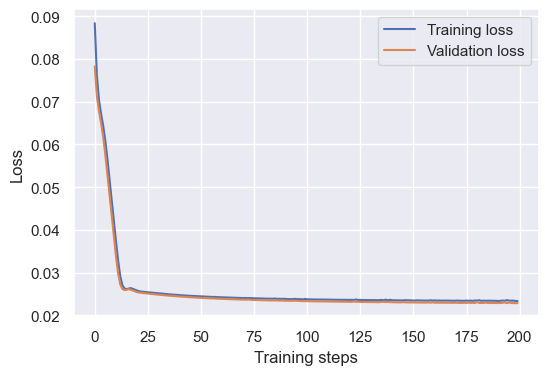

In [18]:
# Plotting the history data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist_forward_ncp_with_deactivation_without_selfloop.history["loss"], label="Training loss")
plt.plot(hist_forward_ncp_with_deactivation_without_selfloop.history["val_loss"], label="Validation loss")

plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [19]:
y_test_forward_activation_with_deactivation_without_selfloop_predicted2 = ncp_model_with_deactivation_without_selfloop.predict(x_test_forward_activation_with_deactivation)

1/1 [==============================] - 1s 1s/step


<Figure size 800x400 with 0 Axes>

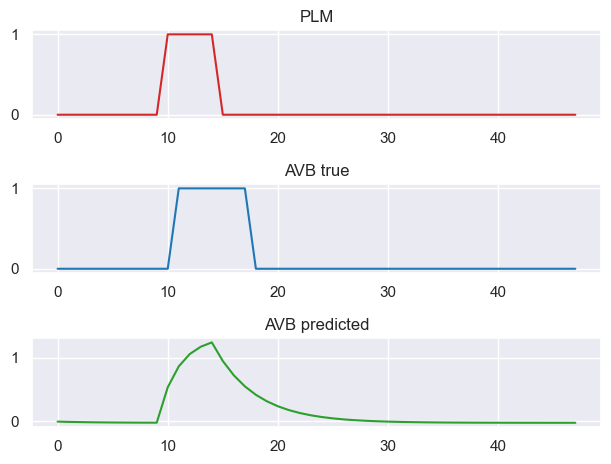

In [20]:
# Plotting the training data
plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(3,1)
axs[0].plot(x_test_forward_activation_with_deactivation[0, :], 'tab:red')
axs[0].set_title('PLM')
axs[1].plot(y_test_forward_activation_with_deactivation[0, :], 'tab:blue')
axs[1].set_title('AVB true')
axs[2].plot(np.squeeze(y_test_forward_activation_with_deactivation_without_selfloop_predicted2[0, :]), 'tab:green')
axs[2].set_title('AVB predicted')


plt.tight_layout()
plt.show()

## Print learned weights

In [21]:
ncp_model_with_deactivation_without_selfloop.variables

[<tf.Variable 'ltc_1/ltc_cell_1/gleak:0' shape=(1,) dtype=float32, numpy=array([0.32717377], dtype=float32)>,
 <tf.Variable 'ltc_1/ltc_cell_1/vleak:0' shape=(1,) dtype=float32, numpy=array([-0.05360315], dtype=float32)>,
 <tf.Variable 'ltc_1/ltc_cell_1/cm:0' shape=(1,) dtype=float32, numpy=array([1.226559], dtype=float32)>,
 <tf.Variable 'ltc_1/ltc_cell_1/sigma:0' shape=(1, 1) dtype=float32, numpy=array([[4.0709934]], dtype=float32)>,
 <tf.Variable 'ltc_1/ltc_cell_1/mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.7816885]], dtype=float32)>,
 <tf.Variable 'ltc_1/ltc_cell_1/w:0' shape=(1, 1) dtype=float32, numpy=array([[0.80199164]], dtype=float32)>,
 <tf.Variable 'ltc_1/ltc_cell_1/erev:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'ltc_1/ltc_cell_1/sensory_sigma:0' shape=(1, 1) dtype=float32, numpy=array([[6.1449885]], dtype=float32)>,
 <tf.Variable 'ltc_1/ltc_cell_1/sensory_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.7816628]], dtype=float32)